In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))
import random
from collections import defaultdict
import itertools
from abc import abstractmethod

import numpy as np
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas
import cv2

from IPython.display import display, Markdown, Latex

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

In [3]:
CHECKPOINT_FOLDER = r'/home/gd1279/scratch/SAYcam-models'
RANDOM_SEED = 33
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = 'cpu'

## StimulusGenerator

Abstract class that describes what we want out of a generator class

In [4]:
DEFAULT_CANVAS_SIZE = (224, 224)

NORMALIZE = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

class StimulusGenerator:
    def __init__(self, dtype=torch.float32):
        self.dtype = dtype
    
    @abstractmethod
    def generate(self, target_position, reference_positions) -> torch.Tensor:
        pass
    
    def __call__(self, target_position, reference_positions) -> torch.Tensor:
        return NORMALIZE(self.generate(target_position, reference_positions))
        
    def batch_generate(self, target_positions, reference_positions) -> torch.Tensor:
        if len(reference_positions) != len(target_positions):
            reference_positions = [reference_positions] * len(target_positions)
        return torch.stack([NORMALIZE(self.generate(t, p)) for (t, p) in zip(target_positions, reference_positions)])
    
    def _to_tensor(self, t):
        return torch.tensor(t, dtype=self.dtype)
    
    def _validate_input_to_tuple(self, input_value, n_args=2):
        if not hasattr(input_value, '__len__') or len(input_value) == 1:
            return (input_value, ) * n_args
        
        return input_value
    
    def _validate_color_input(self, c):
        if isinstance(c, str):
            t = self._to_tensor(colors.to_rgb(c))
        else:
            t = self.to_tensor(self._validate_input_to_tuple(c, 3))
        
        return t.view(3, 1, 1)
    

class NaiveStimulusGenerator(StimulusGenerator):
    def __init__(self, target_size, reference_size, canvas_size=DEFAULT_CANVAS_SIZE,
                 target_color='black', reference_color='blue', background_color='white',
                 dtype=torch.float32):
        super(NaiveStimulusGenerator, self).__init__(dtype)
        
        self.target_size = self._validate_input_to_tuple(target_size)
        self.reference_size = self._validate_input_to_tuple(reference_size)
        self.canvas_size = self._validate_input_to_tuple(canvas_size)
        
        self.target_color = self._validate_color_input(target_color)
        self.reference_color = self._validate_color_input(reference_color)
        self.background_color = self._validate_color_input(background_color)
        
    def generate(self, target_position, reference_positions) -> torch.Tensor:
        x = torch.ones(3, *self.canvas_size, dtype=self.dtype) * self.background_color
        
        # reference first in case of overlap
        for ref_pos in reference_positions:
            x[:, ref_pos[0]:ref_pos[0] + self.reference_size[0],
                 ref_pos[1]:ref_pos[1] + self.reference_size[1]] = self.reference_color
            
        x[:, target_position[0]:target_position[0] + self.target_size[0],
             target_position[1]:target_position[1] + self.target_size[1]] = self.target_color
        
        return x
    


In [5]:
class PatchStimulusGenerator(StimulusGenerator):
    def _patch_to_array(self, patch, size):
        fig = Figure(figsize=(4, 4))
        # attach a non-interactive Agg canvas to the figure
        # (as a side-effect of the ``__init__``)
        canvas = FigureCanvas(fig)
        ax = fig.subplots()
        ax.set_facecolor(np.array(self.background_color).squeeze())
        ax.add_patch(patch)
        ax.set_axis_off()
        ax.autoscale(tight=True)
        # Force a draw so we can grab the pixel buffer
        canvas.draw()
        # grab the pixel buffer and dump it into a numpy array
        X = np.array(canvas.renderer.buffer_rgba())

        row_start = 0
        for i in range(X.shape[0]):
            if not np.all(X[i] == np.array([255, 255, 255,   0])):
                row_start = i
                break

        row_end = X.shape[0]
        for i in range(X.shape[0] - 1, 0, -1):
            if not np.all(X[i] == np.array([255, 255, 255,   0])):
                row_end = i
                break

        col_start = 0
        for i in range(X.shape[1]):
            if not np.all(X[:,i] == np.array([255, 255, 255,   0])):
                col_start = i
                break

        col_end = X.shape[1]
        for i in range(X.shape[1] - 1, 0, -1):
            if not np.all(X[:,i] == np.array([255, 255, 255,   0])):
                col_end = i
                break
                
        X_trim = X[row_start:row_end, col_start:col_end, :]
        X_resized = cv2.resize(X_trim, dsize=size[::-1])
        X_rgb = cv2.cvtColor(X_resized, cv2.COLOR_RGBA2RGB)
        X_float_tensor = torch.tensor(X_rgb, dtype=self.dtype).permute(2, 0, 1)
        return X_float_tensor / X_float_tensor.max()
    
    def __init__(self, target_size, reference_size, target_patch, reference_patch,
                 canvas_size=DEFAULT_CANVAS_SIZE, background_color='white',
                 dtype=torch.float32):
        super(PatchStimulusGenerator, self).__init__(dtype)
        
        self.target_size = self._validate_input_to_tuple(target_size)
        self.reference_size = self._validate_input_to_tuple(reference_size)
        self.canvas_size = self._validate_input_to_tuple(canvas_size)
        
        self.background_color = self._validate_color_input(background_color)
        
        self.target_arr = self._patch_to_array(target_patch, self.target_size)
        self.reference_arr = self._patch_to_array(reference_patch, self.reference_size)
        
    def generate(self, target_position, reference_positions) -> torch.Tensor:
        x = torch.ones(3, *self.canvas_size, dtype=self.dtype) * self.background_color
        
        # reference first in case of overlap
        for ref_pos in reference_positions:
            x[:, ref_pos[0]:ref_pos[0] + self.reference_size[0],
                 ref_pos[1]:ref_pos[1] + self.reference_size[1]] = self.reference_arr
            
        x[:, target_position[0]:target_position[0] + self.target_size[0],
             target_position[1]:target_position[1] + self.target_size[1]] = self.target_arr
        
        return x

In [6]:
BATCH_SIZE = 64


def analyze_single_model(name, model, generator, target_positions, reference_positions=[],
                         batch_size=BATCH_SIZE, random_state=RANDOM_SEED):
    display(Markdown(f'## {name}'))
    
    data = generator.batch_generate(target_positions, reference_positions)
    
    target_pos_array = np.array(target_positions)
    target_pos_distances = np.linalg.norm(target_pos_array[:, None, :] - target_pos_array[None, :, :], axis=-1)
    target_pos_distances /= np.max(target_pos_distances)
    upper_triangle_indices = np.triu_indices_from(target_pos_distances, 1)
    
    target_distance_arr = target_pos_distances[upper_triangle_indices]
    target_distance_arr = (target_distance_arr - target_distance_arr.mean()) / target_distance_arr.std()
    
    dataloader = DataLoader(TensorDataset(data), batch_size=batch_size)
    embeddings = []
    for b in tqdm(dataloader, desc='Batches'):
        embeddings.append(model(b[0].to(device)).detach())

    embeddings = torch.cat(embeddings)
    
    cos = nn.CosineSimilarity(dim=-1)
    if embeddings.shape[1] <= 1024:
        embedding_pairwise_cosine = cos(embeddings[:, None, :], embeddings[None, :, :])
        embedding_cosine_arr = embedding_pairwise_cosine[upper_triangle_indices].cpu().numpy()
        
    else:
        cosines = []
        for i in tqdm(range(embeddings.shape[0]), desc='Indices'):
            remainder = embeddings[i + 1:, :]
            current = embeddings[i,:].repeat(remainder.shape[0], 1)

            cosines.append(cos(current, remainder))

        embedding_cosine_arr = torch.cat(cosines).cpu().numpy()
    
    embedding_cosine_arr = (embedding_cosine_arr - embedding_cosine_arr.mean()) / embedding_cosine_arr.std()
    
    display(Markdown(f'### Correlation coefficients:'))
    display(Markdown('Off-diagonal entries are the correlation, between the pairwise cosine simliarties, and the distances between the target object positions in each pair'))
    print(np.corrcoef(embedding_cosine_arr, target_distance_arr))
    
    pca = PCA(2)
    embeddings_arr = embeddings.cpu().numpy()
    embeddings_pca = pca.fit_transform(embeddings_arr)
    tsne = TSNE(n_jobs=4, init=embeddings_pca, random_state=random_state)
    tsne_out = tsne.fit_transform(embeddings_arr)
    
    display(Markdown(f'------'))
    display(Markdown(f'### t-SNE plots'))
    display(Markdown('Plot on the left: colored by the row (vertical position) of the target object'))
    display(Markdown('Plot on the right: colored by the column (horizontal position) of the target object'))
    plot_tsne(tsne_out, target_positions)
    
    
def plot_tsne(tsne_out, target_positions):
    row_colors = np.array([x[0] for x in target_positions])
    row_colors = row_colors / row_colors.max()

    col_colors = np.array([x[1] for x in target_positions])
    col_colors = col_colors / col_colors.max()
    
    plt.figure(figsize=(20, 8))
    cmap = matplotlib.cm.get_cmap('Spectral_r')

    row_color_ax = plt.subplot(1, 2, 1)
    mappable = row_color_ax.scatter(tsne_out[:, 0], tsne_out[:, 1], c=row_colors, cmap=cmap)
    row_color_ax.set_title('Color by row')

    col_color_ax = plt.subplot(1, 2, 2)
    col_color_ax.scatter(tsne_out[:, 0], tsne_out[:, 1], c=col_colors, cmap=cmap)
    col_color_ax.set_title('Color by column')

    plt.colorbar(mappable)
    plt.show()

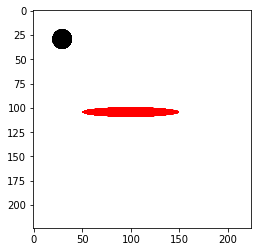

torch.Size([1600, 3, 224, 224])

In [7]:
target_size = 20
reference_size = (10, 100)
reference_positions = [(100, 50)]

target_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='black')
reference_patch = matplotlib.patches.Ellipse((0, 0), width=reference_size[1], 
                                             height=reference_size[0], color='red')

# gen = NaiveStimulusGenerator(target_size, refernce_size, target_color='black', dtype=torch.float32)
gen = PatchStimulusGenerator(target_size, reference_size, target_patch, reference_patch)
x = gen.generate((20, 20), reference_positions)
plt.imshow(x.permute(1, 2, 0).numpy())
plt.show()

every = 5
row_max = DEFAULT_CANVAS_SIZE[0] - target_size
col_max = DEFAULT_CANVAS_SIZE[1] - target_size
target_positions = [(r * every, c * every) for r, c 
                    in itertools.product(range(row_max // every), range(col_max // every))]

batch = gen.batch_generate(target_positions, reference_positions)
batch.shape

## ImageNet-pretrained resnet18

### Correlation coefficients:

Off-diagonal entries are the correlation, between the pairwise cosine simliarties, and the distances between the target object positions in each pair

[[ 1.         -0.02244694]
 [-0.02244694  1.        ]]


------

### t-SNE plots

Plot on the left: colored by the row (vertical position) of the target object

Plot on the right: colored by the column (horizontal position) of the target object

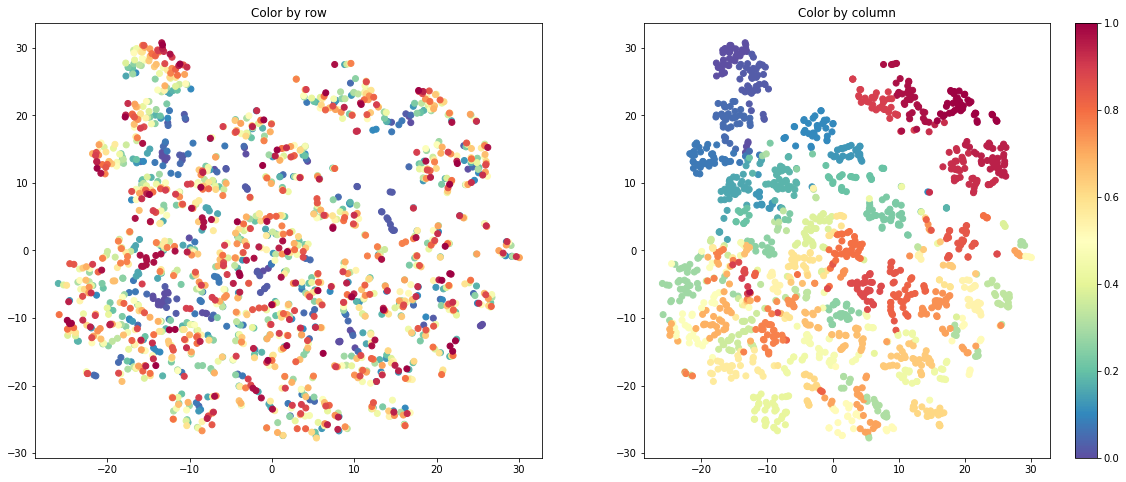

In [8]:
resnet = models.resnet18(pretrained=True)
resnet.fc_backup = resnet.fc
resnet.fc = nn.Sequential()
resnet = resnet.to(device)
analyze_single_model('ImageNet-pretrained resnet18', resnet, gen, target_positions)
del resnet

## ImageNet-pretrained vgg

### Correlation coefficients:

Off-diagonal entries are the correlation, between the pairwise cosine simliarties, and the distances between the target object positions in each pair

[[ 1.         -0.38053079]
 [-0.38053079  1.        ]]


------

### t-SNE plots

Plot on the left: colored by the row (vertical position) of the target object

Plot on the right: colored by the column (horizontal position) of the target object

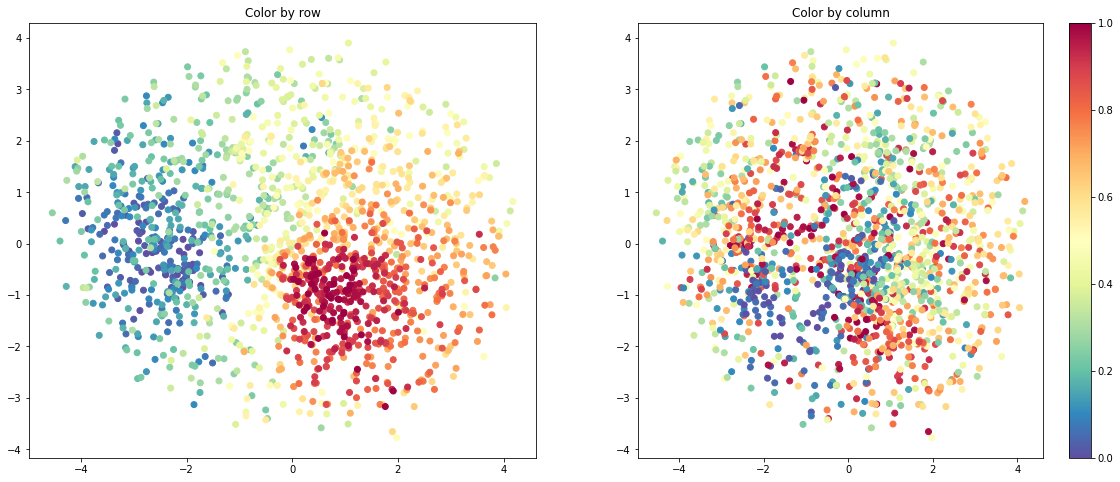

In [9]:
vgg = models.vgg16(pretrained=True)
vgg.fc_backup = vgg.classifier[6]
vgg.classifier[6] = nn.Sequential()
vgg = vgg.to(device)
analyze_single_model('ImageNet-pretrained vgg', vgg, gen, target_positions)
del vgg

## ImageNet-pretrained mobilenet

### Correlation coefficients:

Off-diagonal entries are the correlation, between the pairwise cosine simliarties, and the distances between the target object positions in each pair

[[1.         0.05793923]
 [0.05793923 1.        ]]


------

### t-SNE plots

Plot on the left: colored by the row (vertical position) of the target object

Plot on the right: colored by the column (horizontal position) of the target object

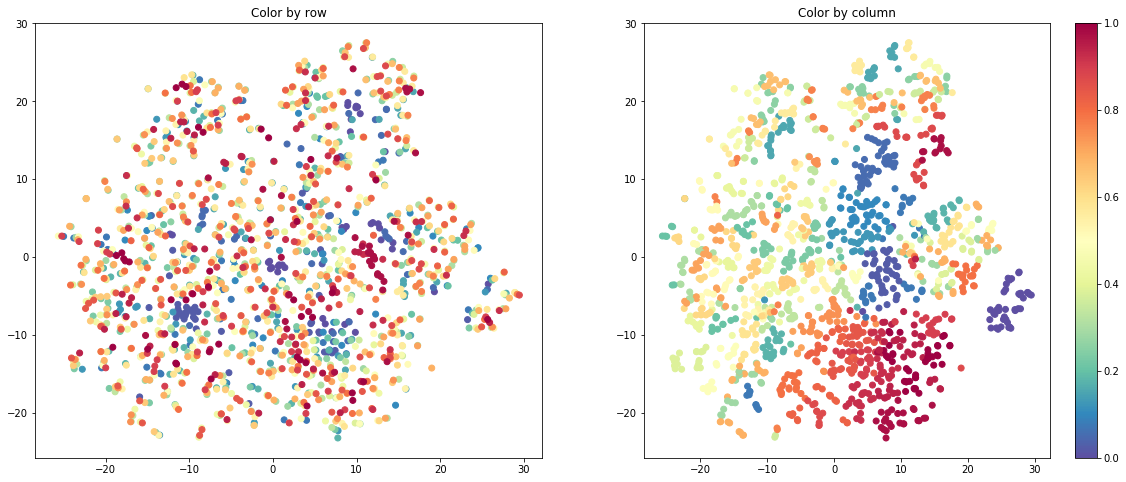

In [10]:
mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet.fc_backup = mobilenet.classifier[1]
mobilenet.classifier[1] = nn.Sequential()
mobilenet = mobilenet.to(device)
analyze_single_model('ImageNet-pretrained mobilenet', mobilenet, gen, target_positions)
del mobilenet

## ImageNet-pretrained resnext50_32x4d

### Correlation coefficients:

Off-diagonal entries are the correlation, between the pairwise cosine simliarties, and the distances between the target object positions in each pair

[[1.        0.1767328]
 [0.1767328 1.       ]]


------

### t-SNE plots

Plot on the left: colored by the row (vertical position) of the target object

Plot on the right: colored by the column (horizontal position) of the target object

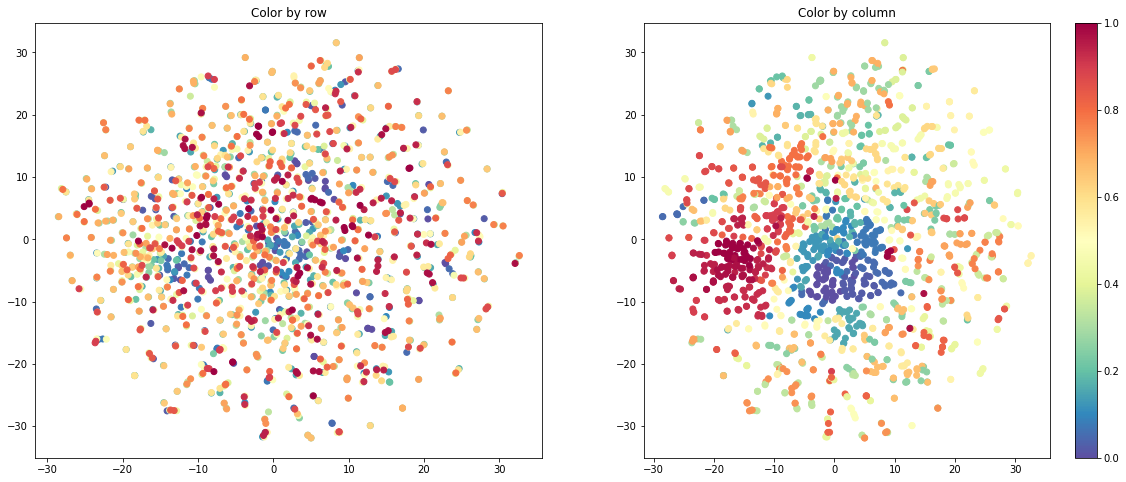

In [11]:
resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
resnext50_32x4d.fc_backup = resnext50_32x4d.fc
resnext50_32x4d.fc = nn.Sequential()
resnext50_32x4d = resnext50_32x4d.to(device)
analyze_single_model('ImageNet-pretrained resnext50_32x4d', resnext50_32x4d, gen, target_positions)
del resnext50_32x4d

## TC-SAY-mobilenet

### Correlation coefficients:

Off-diagonal entries are the correlation, between the pairwise cosine simliarties, and the distances between the target object positions in each pair

[[ 1.         -0.46036636]
 [-0.46036636  1.        ]]


------

### t-SNE plots

Plot on the left: colored by the row (vertical position) of the target object

Plot on the right: colored by the column (horizontal position) of the target object

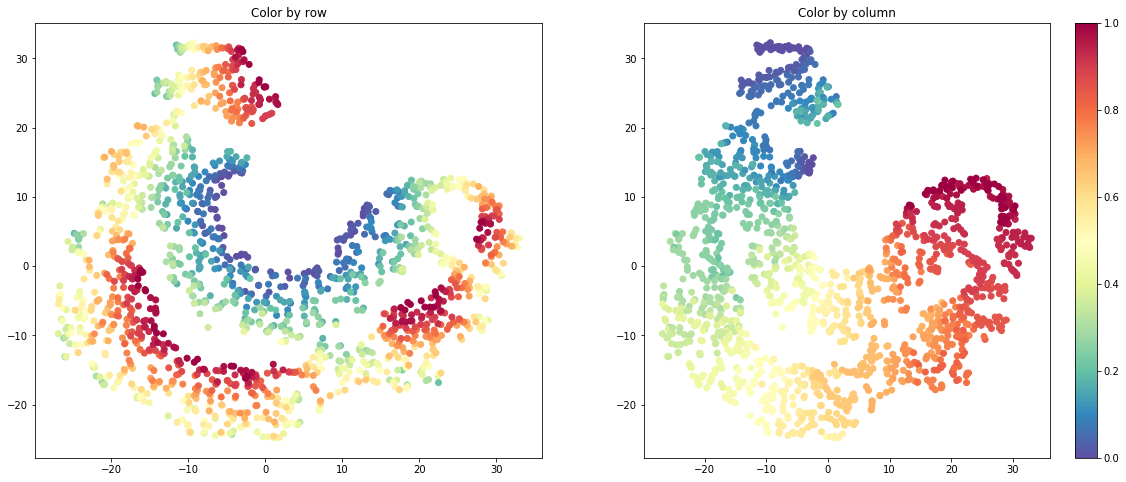

In [12]:
saycam_mobilenet = models.mobilenet_v2(pretrained=False)
saycam_mobilenet = nn.DataParallel(saycam_mobilenet)
saycam_mobilenet = saycam_mobilenet.to(device)
saycam_mobilenet.module.classifier = nn.Linear(1280, 6269)

saycam_mobilenet_checkpoint = torch.load(os.path.join(CHECKPOINT_FOLDER, 'TC-SAY-mobilenet.tar'))
saycam_mobilenet.load_state_dict(saycam_mobilenet_checkpoint['model_state_dict'])

saycam_mobilenet.module.classifier = nn.Sequential()

analyze_single_model('TC-SAY-mobilenet', saycam_mobilenet, gen, target_positions)
del saycam_mobilenet

## TC-S-mobilenet

### Correlation coefficients:

Off-diagonal entries are the correlation, between the pairwise cosine simliarties, and the distances between the target object positions in each pair

[[ 1.       -0.467643]
 [-0.467643  1.      ]]


------

### t-SNE plots

Plot on the left: colored by the row (vertical position) of the target object

Plot on the right: colored by the column (horizontal position) of the target object

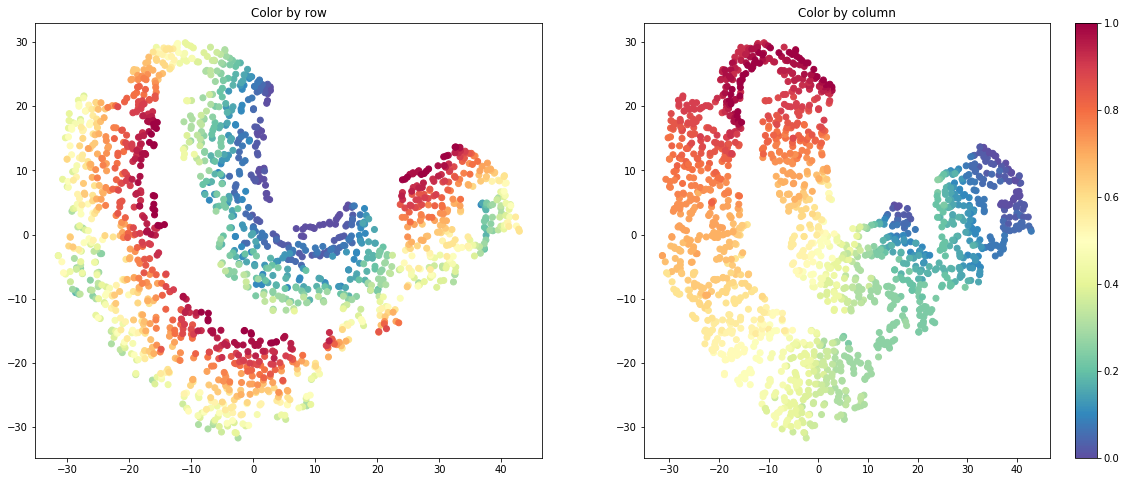

In [13]:
s_mobilenet = models.mobilenet_v2(pretrained=False)
s_mobilenet = nn.DataParallel(s_mobilenet)
s_mobilenet = s_mobilenet.to(device)
s_mobilenet.module.classifier = nn.Linear(1280, 2765)

s_mobilenet_checkpoint = torch.load(os.path.join(CHECKPOINT_FOLDER, 'TC-S-mobilenet.tar'))
s_mobilenet.load_state_dict(s_mobilenet_checkpoint['model_state_dict'])

s_mobilenet.module.classifier = nn.Sequential()

analyze_single_model('TC-S-mobilenet', s_mobilenet, gen, target_positions)
del s_mobilenet

## TC-SAY-resnext

### Correlation coefficients:

Off-diagonal entries are the correlation, between the pairwise cosine simliarties, and the distances between the target object positions in each pair

[[ 1.         -0.07146117]
 [-0.07146117  1.        ]]


------

### t-SNE plots

Plot on the left: colored by the row (vertical position) of the target object

Plot on the right: colored by the column (horizontal position) of the target object

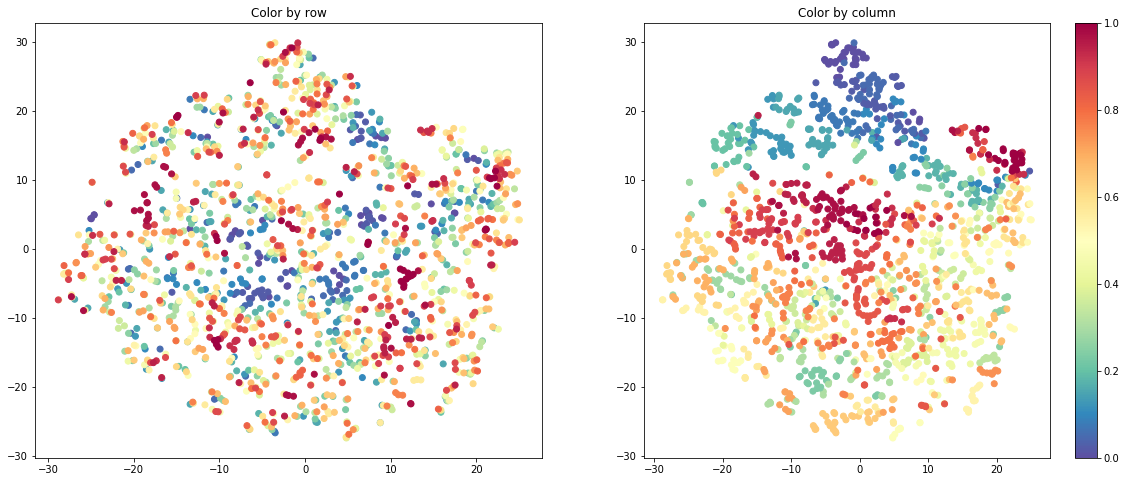

In [14]:
saycam_resnext50_32x4d = models.resnext50_32x4d(pretrained=False)
saycam_resnext50_32x4d = nn.DataParallel(saycam_resnext50_32x4d)
saycam_resnext50_32x4d.module.fc = nn.Linear(2048, 6269)

saycam_resnext50_checkpoint = torch.load(os.path.join(CHECKPOINT_FOLDER, 'TC-SAY-resnext.tar'))
saycam_resnext50_32x4d.load_state_dict(saycam_resnext50_checkpoint['model_state_dict'])

saycam_resnext50_32x4d.module.fc = nn.Sequential()

analyze_single_model('TC-SAY-resnext', saycam_resnext50_32x4d, gen, target_positions)
del saycam_resnext50_32x4d

## TC-S-resnext

### Correlation coefficients:

Off-diagonal entries are the correlation, between the pairwise cosine simliarties, and the distances between the target object positions in each pair

[[ 1.         -0.37897102]
 [-0.37897102  1.        ]]


------

### t-SNE plots

Plot on the left: colored by the row (vertical position) of the target object

Plot on the right: colored by the column (horizontal position) of the target object

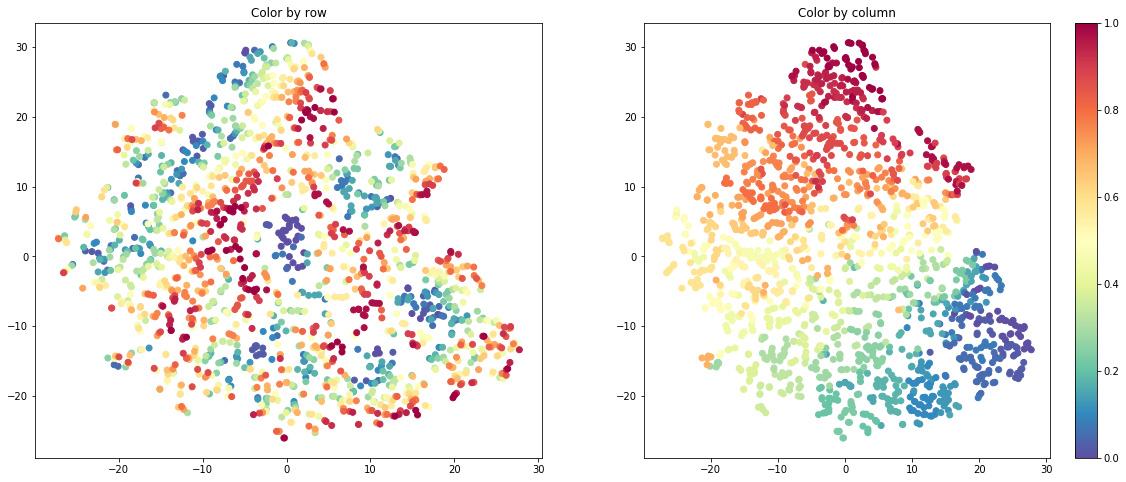

In [15]:
s_resnext50_32x4d = models.resnext50_32x4d(pretrained=False)
s_resnext50_32x4d = nn.DataParallel(s_resnext50_32x4d)
s_resnext50_32x4d.module.fc = nn.Linear(2048, 2765)

s_resnext50_checkpoint = torch.load(os.path.join(CHECKPOINT_FOLDER, 'TC-S-resnext.tar'))
s_resnext50_32x4d.load_state_dict(s_resnext50_checkpoint['model_state_dict'])

s_resnext50_32x4d.module.fc = nn.Sequential()

analyze_single_model('TC-S-resnext', s_resnext50_32x4d, gen, target_positions)
del s_resnext50_32x4d